In [1]:
import numpy as np
import time
import math
import modules as md
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
import matplotlib.patches as mpatches




#------------------------------------------------------------------------------------------
#Units and conversions:
#------------------------------------------------------------------------------------------
#code units: Rsun, Msun, G=1, ...
c_SI       = 299792458.0        #m/s
M_sun_SI   = 1.989*(10.**30.)   #kg
R_sun_SI   = 695800000.         #m
R_bull_SI = 1000 #m 
AU_SI      = 149597871000.      #m 
G_new_SI   = 6.67*(10.**(-11.)) #m**3 kg**(-1) s**(-2)
AU_U       = AU_SI/R_sun_SI                             #from dist AU to code units (U)
kmsec_U    = 1000./np.sqrt(G_new_SI*M_sun_SI/R_bull_SI)  #from vel km/sec to code units (U)
time_U     = 1/np.sqrt(G_new_SI*M_sun_SI/R_bull_SI**3) #from CU to second np.sqrt((R_bull_SI)/(G_new_SI*M_sun_SI)) #from code units(U) to time sec
#Rsch_1Msun_unitRsun = ((2.*G_new_SI*(1.*M_sun_SI))/(c_SI**2.))/R_sun_SI
c_CU = c_SI/1000*kmsec_U

In [12]:
#Newton
#Acceleration

def acc(r,m): #r position, m mass
    a = np.zeros((len(r),3)) #Create acceleration vector
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                rrel = r[i]-r[j]
                rn = (rrel**2).sum()**(1./2) 
                a[i] += -(rrel)*m[j]/(rn**3.0) #Acceleration at each time step 
    return a # return acceleration


def Jerk(r,v,m): #position, velocity, mass
    Je = np.zeros((len(r),3)) #Define the Jerk
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = r[i]-r[j]
                vrel = v[i]-v[j]
                rn = (rrel**2).sum()**(1./2) # dot product
                vn = (vrel**2).sum()**(1./2)
                rvd = ((rrel)*(vrel)).sum()
                Je[i] += - m[j]*((vrel)/rn**3.0 - 3.*(rvd*rrel/(rn**5.0))) 
    return Je;

#PN
#PN Acceleration
def accPN(r,v,m): #r position, m mass, s spin, m mass of secondary
    a = np.zeros((len(r),3)) #Create acceleration vector
    a1 = np.zeros((len(r),3)) #Create acceleration vector
    a2 = np.zeros((len(r),3)) #Create acceleration vector

    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle           
            if (i != j):
                rrel = r[i]-r[j] 
                vrel = v[i]-v[j]
                rn = ((rrel**2).sum())**(1./2) #dot product
                runi = 1.*rrel/rn
                #rvd = ((rrel)*(vrel)).sum()
                ruvd = ((runi)*(vrel)).sum()
                v2d = (vrel**2).sum()
                a1[i] += +(4./5)*(1./c_CU**5)*(m[i]*m[j]/(rn**3))*((2*m[i]/rn - 8*m[j]/rn - v2d)*vrel)
                a2[i] += +(4./5)*(1./c_CU**5)*(m[i]*m[j]/(rn**3))*(runi*(ruvd)*(52.0*m[j]/(3*rn) - 6*m[i]/rn + 3.0*v2d))
                a[i] += a1[i] + a2[i] #a1[i] +  
    return a#, a1, a2 # return acceleration


#PN Jerk v2

def JerkPN(r,v,a,m): #position, velocity, mass
    JePNLO3 = np.zeros((len(r),3))
    JePNLO3v2 = np.zeros((len(r),3))
    JePNLO4 = np.zeros((len(r),3))
    JePNLO5 = np.zeros((len(r),3))#Define the Jerk
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = r[i]-r[j] 
                vrel = v[i]-v[j]
                arel = a[i]-a[j]
                rn = ((rrel**2).sum())**(1./2) #norm                                                    
                vn = ((vrel**2).sum())**(1./2) 
                runi = 1.*rrel/rn
                ruvd = (runi*vrel).sum()   
                ruad = (runi*arel).sum()                                                  
                vad = (vrel*arel).sum()
                JePNLO3[i] += (4./5)*(1./(c_CU**5))*(m[j]*m[i]/(rn**3))*(-(vn**2)*arel + 2*vad*vrel + 3*((ruvd*(vn**2)*vrel) + 2*( vad*ruvd + (vn**2)*ruad)*runi))                
                JePNLO4[i] += (4./5)*(1./(c_CU**5))*(m[j]*m[i]/(rn**4))*(3*ruvd*(vn**2)*vrel + 2*(m[i]-m[j])*arel+ 3*(vn**4)*runi - 15*(ruvd**2)*(vn**2)*runi + ((52./3)*m[j]-6*m[i])*(ruad)*runi)
                JePNLO5[i] += (4./5)*(1./(c_CU**5))*(m[j]*m[i]/(rn**5))*(-8*(m[i] - m[j])*(ruvd)*vrel + ((52./3)*m[j]-6*m[i])*((vn**2)*runi + ruvd*vrel - 6*((ruvd**2)*runi)))
                JePNLOt = JePNLO3 + JePNLO4 + JePNLO5 
    return JePNLOt 

#Static Tides
def acctide(r,m,ne): #r position, m mass, s spin, m mass of the star and the value of ne
    a = np.zeros((len(r),3)) #Create acceleration vector
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                rvec = r[i,:]-r[j,:]
                ra = ((rvec**2).sum())**(1./2) #dot product
                runi = rvec/ra
                a[i] += -(9.)*ne[i]*((m[j]**2)/m[i])*(runi)/(ra**7.0) #Acceleration at each time step 
    return a # return acceleration

def Jerktide(r,v,m, ne): #r position, v velocity, m mass, m mass of the star, ne
    Je = np.zeros((len(r),3)) #Define the Jerk
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = (r[i]-r[j])
                vrel = (v[i]-v[j])
                rn = ((rrel**2).sum())**(1./2) # dot product
                Je[i] += - (9.0)*ne[i]*((m[j]**2)/m[i])*( vrel/rn**8.0 - 8.*((vrel*rrel).sum())*(rrel)/(rn**10.0) ) 
    return Je;

#Dynamical Tides

def accdytide(r,v,m,ne): #r position, m mass, s spin, m mass of the star and the value of ne
    a = np.zeros((len(r),3)) #Create acceleration vector
    a1 = np.zeros((len(r),3))
    a2 = np.zeros((len(r),3))
    a3 = np.zeros((len(r),3))
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                rrel = r[i]-r[j]
                vrel = v[i]-v[j]
                vn = ((vrel**2).sum())**(1./2)
                rn = ((rrel**2).sum())**(1./2) #dot product
                runi = rrel/rn
                a1[i] += -(36.)*ne[i]*((m[j]**2)/m[i])*(runi)*(vn**2)/(rn**9.0) #Acceleration at each time step 
                a2[i] += -(90.)*ne[i]*((m[j]**2)/m[i])*(runi)*((runi*vrel).sum()**2)/(rn**9.0)
                a3[i] += +(18.)*ne[i]*((m[j]**2)/m[i])*(vrel)*((runi*vrel).sum())/(rn**9.0)
                a[i] += a1[i] + a2[i] + a3[i]
    return a # return acceleration


def Jerkdytide(r,v, a, m, ne): #r position, v velocity, m mass, m mass of the star, ne
    Je = np.zeros((len(r),3)) #Define the Jerk
    Je1 = np.zeros((len(r),3))
    Je2 = np.zeros((len(r),3))
    Je3 = np.zeros((len(r),3))
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = (r[i]-r[j])
                vrel = (v[i]-v[j])
                arel = (a[i]-a[j])
                rn = ((rrel**2).sum())**(1./2) # dot product
                vn = ((vrel**2).sum())**(1./2)
                Je1[i] += - (36.0)*ne[i]*((m[j]**2)/m[i])*( vrel*(vn**2)/rn**(10.0) - 10.*(vn**2)*((vrel*rrel).sum())*(rrel)/(rn**12.0) + 72*((vrel*arel).sum())/(rn**9.0) )
                Je2[i] += -(90.)*ne[i]*((m[j]**2)/m[i])*((2*((rrel*vrel).sum())*( (arel*vrel).sum() + vn**2 )*rrel + vrel*((rrel*vrel).sum()**2))/(rn**12.) - (12*((rrel*vrel).sum()**3)*rrel )/(rn**14.) )
                Je3[i] += +(18.)*ne[i]*((m[j]**2)/m[i])*( (arel*((rrel*vrel).sum()) + vrel*( (rrel*arel).sum() + vn**2 ) )/(rn**10.)  -10*vrel*((rrel*vrel).sum()**2)/(rn**12.)  )
                Je[i] = Je1[i] + Je2[i] + Je3[i]
    return Je;

# Integrator with PN and Oscillations 

In [33]:
def HermiteUpdatePNdytidedt(dt, r, v, m, ns, no): # m mass of the star
    
    aN = acc(r, m) 
    aT = acctide(r, m, ns)
    aO = accdytide(r, v, m, no)
    aPN = accPN(r, v, m)
    a = aN + aPN + aT + aO # current acceleration
    
    aNdot = Jerk(r,v,m)
    aTdot = Jerktide(r, v, m, ns)
    aOdot = Jerkdytide(r, v, a, m, no)
    aPNdot = JerkPN(r, v, a, m)
    adot = aNdot + aPNdot + aTdot + aOdot # current jerks
    
    rp = r + dt*v + dt**2/2 * a + dt**3/6* adot   # predict
    vp = v + dt*a + dt**2/2 * adot

    aNp = acc(rp, m)
    aPNp = accPN(rp, vp, m)
    aTp = acctide(rp, m, ns)
    aOp = accdytide(rp, vp, m, no)
    ap = aNp + aPNp + aTp +aOp        # predicted acceleration

    aNdotp = Jerk(rp, vp, m)
    aPNdotp = JerkPN(rp, vp, ap, m)
    aTdotp = Jerktide(rp, vp, m, ns)
    aOdotp = Jerkdytide(rp, vp, ap, m, no)
    adotp = aNdotp + aPNdotp +  aTdotp + aOdotp
    
    dtp = dt
    
    vc = v + dt/2*(a+ap) - dt**2/12*(adotp-adot)  # correct
    rc = r + dt/2*(v + vp) - dt**2/12 * (ap-a)
    ac = a + dt/2*(adotp+adot)

 
    return rc,vc,dtp #ap,adotp,aNp,aNdotp,

def Hermite4thPNdytidedt(pri,sec, bina, nsteps, Dt):
    
    N=2
    m = np.ones(N)#/N #Remove the N if not necessary
    m[0]=pri.mass
    m[1]=sec.mass
    
    r_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    v_res = np.zeros((2,3,nsteps))

    #aN_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    #adotN_res = np.zeros((2,3,nsteps))

    #a_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    #adot_res = np.zeros((2,3,nsteps))

    
    time = np.zeros(nsteps)
    r_res[:,:,0] = bina.r.copy()
    v_res[:,:,0] = bina.v.copy()
    ntidev = np.array([pri.ntide, sec.ntide])
    ndtidev = np.array([pri.ndtide, sec.ndtide])
    
    dtp = np.zeros(nsteps)
    dtp[0] = Dt
    
    for i in range(1,nsteps):
        (r_res[:,:,i],v_res[:,:,i], dtp[i]) = HermiteUpdatePNdytidedt(Dt, r_res[:,:,i-1], v_res[:,:,i-1], m, ntidev, ndtidev)
        time[i] = time[i-1] + dtp[i-1] #+ Dt #
        if time[i] >= timelimit:
            break
        #elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 1.*(pri.radi+sec.radi): #This is when running an equal mass bbh
        elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 2.*(bina.tidalrsec):
            break
    
    
    #for i in range(1,nsteps):
    #    (r_res[:,:,i],v_res[:,:,i],a_res[:,:,i],adot_res[:,:,i],aN_res[:,:,i],adotN_res[:,:,i], dtp[i]) = HermiteUpdatetidedt(Dt, r_res[:,:,i-1], v_res[:,:,i-1], m, ntidev)
    #    time[i] = time[i-1] + dtp[i-1] #+ Dt #
    #    if time[i] >= timelimit:
    #        break
            
    r_res = r_res[:,:,:i]
    v_res = v_res[:,:,:i]
    #a_res = a_res[:,:,:i]
    #adot_res = adot_res[:,:,:i]
    #aN_res = aN_res[:,:,:i]
    #adotN_res = adotN_res[:,:,:i]
    dtp = dtp[:i]
    time = time[:i]
        
    return r_res, v_res, time #, aN_res, adotN_res, a_res, adot_res, 


In [34]:
#Define ns
ns = md.Particle("NS",1.2,8.89,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius
#Define bh
#bh3 = md.Particle("BH",5,0,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius

#Define binary
nsnscol = md.Binary(ns, ns, ns.radi*8, 0) ##primary, secondary, orbital distance (Rsun), eccentricity

In [137]:
tl = 30*nsnscol.periodct #Time of the simulation in [cpde units]
timelimit = tl #
dt = 0.005 # 0.0001 working better 
Nsteps = int(tl/dt)#Number of timesteps with the guessed timestep 

In [138]:
rPNTO,vPNTO,timePNTO = Hermite4thPNdytidedt(ns,ns, nsnscol, Nsteps, dt)

KeyboardInterrupt: 

No handles with labels found to put in legend.


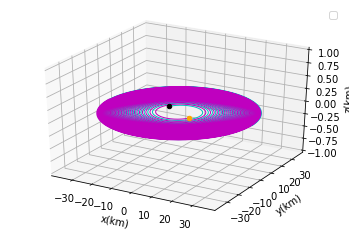

In [37]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(rPNTO[0][0], rPNTO[0][1], rPNTO[0][2], 'c', linewidth=1)# Plot the BH orbit
ax.plot(rPNTO[1][0], rPNTO[1][1], rPNTO[1][2], 'm', linewidth=1)# Plot the star orbit
ax.scatter3D(rPNTO[0][0][-1], rPNTO[0][1][-1], rPNTO[0][2][-1], '0', c='black') #s=100 markersize=40
ax.scatter3D(rPNTO[1][0][-1], rPNTO[1][1][-1], rPNTO[1][2][-1], 'o', c='orange') #s=10
ax.legend()
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
#ax.set_xlim3d(-1,1)
ax.set_zlim3d(-1,1)
#ax.set_xlim3d(min(min(posbh1x), min(posbh2x)), max(max(posbh1x), max(posbh2x)))
#ax.set_ylim3d(min(min(posbh1y), min(posbh2y)), max(max(posbh1y), max(posbh2y)))
#ax.set_zlim3d(min(min(posbh1z), min(posbh2z)), max(max(posbh1z), max(posbh2z)))
ax.set_xlabel('x(km)')
ax.set_ylabel('y(km)')
ax.set_zlabel('z(km)')


#plt.savefig('TPNcol.png', bbox_inches='tight', dpi=300)#, dpi=200
#plt.savefig('PNorbitaldecay.eps', format='eps')#,

plt.show()

In [ ]:
np.linalg.norm(rrelPNTO.T[-1])

In [ ]:
rrelPNTO = rPNTO[0] - rPNTO[1]
vrelPNTO = vPNTO[0] - vPNTO[1]
#rfnsbh = rrelnsbh.T[-1]

#Obtain the orbital distance
dPNTO = np.zeros(len(rrelPNTO .T)) 

for i in range(len(rrelPNTO.T)):
    dPNTO[i] = np.linalg.norm(rrelPNTO.T[i])
    
#Obtain the relative velocity
vnPNTO = np.zeros(len(vrelPNTO.T)) 

for i in range(len(vrelPNTO.T)):
    vnPNTO[i] = np.linalg.norm(vrelPNTO.T[i])

In [ ]:
vnPNTOkm = vnPNTO/kmsec_U*1000/c_SI
timePNTOsec = timePNTO*time_U

In [ ]:
wsPNTO = np.zeros([len(dPNTO)])

for i in range(len(dPNTO)):
    wsPNTO[i] = ((ns.mass+ns.mass)/dPNTO[i]**3)**(1./2) 
    
hplusPNTO = np.zeros([len(dPNTO)]) #Could use Nsteps
#hcrossnsbh = np.zeros([len(dsimnsbh)])
#ro = 1.23*10**(22)#in km. LIGO's first detection, generated by two black holes some 1.3 billion light years away.
ro = 1.23*10**(21)

iangle = np.pi/2# i = pi/2 -> hx vanishes, i = 0 -> h+ and h- have the same amplitude

mu = (ns.mass*ns.mass)/(ns.mass+ns.mass)

for i in range(len(dPNTO)):
    hplusPNTO[i] = (1./ro)*(4*mu*(wsPNTO[i]**2)*(dPNTO[i]**2)/c_CU**4)*((1+np.cos(iangle)**2)/2)*np.cos(2*wsPNTO[i]*timePNTO[i])
    #hcross[i] = (1./ro)*(4*mu*(ws[i]**2)*(dsim[i]**2)/c_CU**4)*np.cos(iangle)*np.sin(2*ws[i]*timesimtp[i])

In [ ]:
plt.plot(timePNTOsec, hplusPNTO, 'y-')
plt.axis([min(timePNTO), max(timePNTOsec), 1.2*min(hplusPNTO), 1.2*max(hplusPNTO)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gwnsbh.png', format='png', dpi=200)
plt.show()

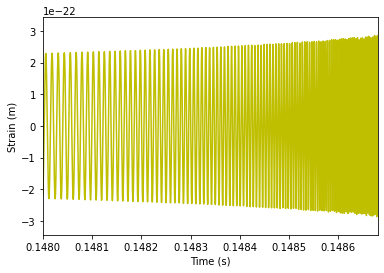

In [50]:
plt.plot(timePNTOsec, hplusPNTO, 'y-')
plt.axis([0.148, max(timePNTOsec), 1.2*min(hplusPNTO), 1.2*max(hplusPNTO)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gwnsbh.png', format='png', dpi=200)
plt.show()

# Only PN 

In [63]:
def HermiteUpdatePNtdt(dt, r, v, m): # m mass of the star
    
    aN = acc(r, m) 
    #aD = accdiss(r, m, ns)
    aPN = accPN(r, v, m)
    a = aN + aPN #+ aT # current acceleration
    
    aNdot = Jerk(r,v,m)
    #aDdot = Jerkdiss(r, v, m, ns)
    aPNdot = JerkPN(r, v, a, m)
    adot = aNdot + aPNdot #+ aDdot # current jerks
    
    rp = r + dt*v + dt**2/2 * a + dt**3/6* adot   # predict
    vp = v + dt*a + dt**2/2 * adot

    aNp = acc(rp, m)
    aPNp = accPN(rp, vp, m)
    #aDp = accdiss(rp, m, ns)
    ap = aNp + aPNp #+ aDp        # predicted acceleration

    aNdotp = Jerk(rp, vp, m)
    aPNdotp = JerkPN(rp, vp, ap, m)
    #aDdotp = Jerkdiss(rp, vp, m, ns)
    adotp = aNdotp + aPNdotp #+  aDdotp  # predicted jerks 
    
    dtp = dt
    
    vc = v + dt/2*(a+ap) - dt**2/12*(adotp-adot)  # correct
    rc = r + dt/2*(v + vp) - dt**2/12 * (ap-a)
    ac = a + dt/2*(adotp+adot)

 
    return rp,vp,dtp #ap,adotp,aNp,aNdotp,

def Hermite4thPNtdt(pri,sec, bina, nsteps, Dt):
    
    N=2
    m = np.ones(N)#/N #Remove the N if not necessary
    m[0]=pri.mass
    m[1]=sec.mass
    
    r_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    v_res = np.zeros((2,3,nsteps))

    #aN_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    #adotN_res = np.zeros((2,3,nsteps))

    #a_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    #adot_res = np.zeros((2,3,nsteps))

    
    time = np.zeros(nsteps)
    r_res[:,:,0] = bina.r.copy()
    v_res[:,:,0] = bina.v.copy()
    #ntidev = np.array([pri.eta, sec.eta])
    
    dtp = np.zeros(nsteps)
    dtp[0] = Dt
    
    for i in range(1,nsteps):
        (r_res[:,:,i],v_res[:,:,i], dtp[i]) = HermiteUpdatePNtdt(Dt, r_res[:,:,i-1], v_res[:,:,i-1], m)
        time[i] = time[i-1] + dtp[i-1] #+ Dt #
        if time[i] >= timelimit:
            break
        #elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 1.*(pri.radi+sec.radi): #This is when running an equal mass bbh
        elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 2.*(bina.tidalrsec):
            break
    
    
    #for i in range(1,nsteps):
    #    (r_res[:,:,i],v_res[:,:,i],a_res[:,:,i],adot_res[:,:,i],aN_res[:,:,i],adotN_res[:,:,i], dtp[i]) = HermiteUpdatetidedt(Dt, r_res[:,:,i-1], v_res[:,:,i-1], m, ntidev)
    #    time[i] = time[i-1] + dtp[i-1] #+ Dt #
    #    if time[i] >= timelimit:
    #        break
            
    r_res = r_res[:,:,:i]
    v_res = v_res[:,:,:i]
    #a_res = a_res[:,:,:i]
    #adot_res = adot_res[:,:,:i]
    #aN_res = aN_res[:,:,:i]
    #adotN_res = adotN_res[:,:,:i]
    dtp = dtp[:i]
    time = time[:i]
        
    return r_res, v_res, time #, aN_res, adotN_res, a_res, adot_res, 


In [ ]:
rPN,vPN,timePN = Hermite4thPNtdt(ns,ns, nsnscol, Nsteps, dt)


In [ ]:
rrelPN = rPN[0] - rPN[1]
vrelPN = vPN[0] - vPN[1]
#rfnsbh = rrelnsbh.T[-1]

#Obtain the orbital distance
dPN = np.zeros(len(rrelPN .T)) 

for i in range(len(rrelPN.T)):
    dPN[i] = np.linalg.norm(rrelPN.T[i])
    
#Obtain the relative velocity
vnrelPN = np.zeros(len(vrelPN.T))

for i in range(len(rrelPN.T)):
    vnrelPN[i] = np.linalg.norm(vrelPN.T[i])
    
vnrelPNkm = vnrelPN/kmsec_U*1000/c_SI
timePNsec = timePN*time_U

In [ ]:
wsPN = np.zeros([len(dPN)])

for i in range(len(dPN)):
    wsPN[i] = ((ns.mass+ns.mass)/dPN[i]**3)**(1./2) 
    
hplusPN = np.zeros([len(dPN)]) #Could use Nsteps
#hcrossnsbh = np.zeros([len(dsimnsbh)])
#ro = 1.23*10**(22)#in km. LIGO's first detection, generated by two black holes some 1.3 billion light years away.
ro = 1.23*10**(21)

iangle = np.pi/2# i = pi/2 -> hx vanishes, i = 0 -> h+ and h- have the same amplitude

mu = (ns.mass*ns.mass)/(ns.mass+ns.mass)

for i in range(len(dPN)):
    hplusPN[i] = (1./ro)*(4*mu*(wsPN[i]**2)*(dPN[i]**2)/c_CU**4)*((1+np.cos(iangle)**2)/2)*np.cos(2*wsPN[i]*timePN[i])
    #hcross[i] = (1./ro)*(4*mu*(ws[i]**2)*(dsim[i]**2)/c_CU**4)*np.cos(iangle)*np.sin(2*ws[i]*timesimtp[i])
    

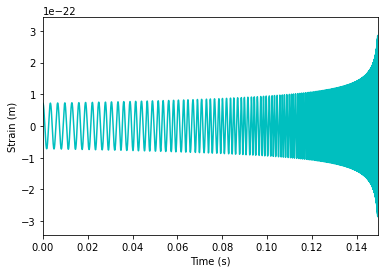

In [67]:
plt.plot(timePNsec, hplusPN, 'c-')
plt.axis([min(timePNsec), max(timePNsec), 1.2*min(hplusPN), 1.2*max(hplusPN)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gwnsbh.png', format='png', dpi=200)
plt.show()

# Comparison of Waveforms 

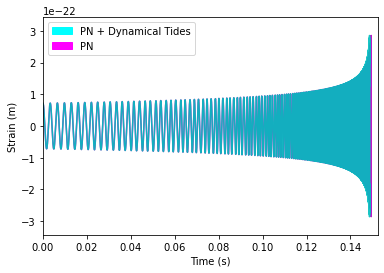

In [70]:
cyan_patch = mpatches.Patch(color='cyan', label=r'PN + Dynamical Tides')
magenta_patch = mpatches.Patch(color='magenta', label=r'PN')
plt.legend(handles=[cyan_patch, magenta_patch])
plt.plot(timePNsec, hplusPN, 'm-', alpha = 0.9)
plt.plot(timePNTOsec, hplusPNTO, 'c-', alpha = 0.9)
plt.axis([min(timePNsec), 1.02*max(timePNsec), 1.2*min(hplusPN), 1.2*max(hplusPN)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gw-TOPNvsTPN.png', bbox_inches='tight', dpi=200) #, dpi=300
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


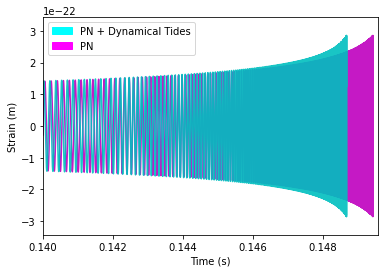

In [75]:
cyan_patch = mpatches.Patch(color='cyan', label=r'PN + Dynamical Tides')
magenta_patch = mpatches.Patch(color='magenta', label=r'PN')
plt.legend(handles=[cyan_patch, magenta_patch])
plt.plot(timePNsec, hplusPN, 'm-', alpha = 0.9)
plt.plot(timePNTOsec, hplusPNTO, 'c-', alpha = 0.9)
plt.axis([0.14, 1.0009*max(timePNsec), 1.2*min(hplusPN), 1.2*max(hplusPN)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gw-PNvsPNTO-8rs-01.eps', bbox_inches='tight') #, dpi=300
plt.show()

# Spinning objects 

In [78]:
def accspin(r,m,ns,S):#r,m,S,ns #r position, m mass, s spin, m mass of the star and the value of ne
    a = np.zeros((len(r),3)) #Create acceleration vector
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                rrel = r[i]-r[j]
                rn = ((rrel**2).sum())**(1./2) #dot product
                runi = rrel/rn
                Sn = ((S[i]*S[i]).sum())**(1./2)
                a[i] += -(3./2)*ns[i]*(m[j]*Sn**2/m[i])*(runi)/(rn**4.0) #Acceleration at each time step
                
    return a # return acceleration

def Jerkspin(r,v,m, ns,S):#r,v,m,S,ns #r position, v velocity, m mass, m mass of the star, ne
    Je = np.zeros((len(r),3)) #Define the Jerk
    Je1 = np.zeros((len(r),3))
    Je2 = np.zeros((len(r),3))
    for i in range(len(r)):
        for j in range(len(r)):
            if (i != j):
                rrel = (r[i]-r[j])
                vrel = (v[i]-v[j])
                rn = ((rrel**2).sum())**(1./2) # dot product
                Sn = ((S[i]*S[i]).sum())**(1./2)
                #Je1[i] += - (3./2)*ns[i]*((m[j])/m[i])*(2*((S*b).sum())*rrel/r**5 ) #Still need to define b 
                Je2[i] += - (3./2)*ns[i]*((m[j])/m[i])*(Sn**2)*(vrel/rn**5.0 - 5.*((vrel*rrel).sum())*(rrel)/(rn**7.0))               
                Je[i] += Je2[i] #Je1[i] + Je2[i] 
    return Je;

def bccspin(r,v,m,ns,S,I): #r position, m mass, s spin, m mass of the star
    b = np.zeros((len(r),3)) #Create acceleration vector
    b1 = np.zeros((len(r),3))
    b2 = np.zeros((len(r),3))
    #bden = np.zeros((len(r),3))
    for i in range(len(r)): #Range is size of timesteps or position steps
        for j in range(len(r)): #For each particle
            if (i != j):
                if(ns[i] == 0.0):
                    b[i] = np.array([0,0,0])
                elif (ns[i] != 0):
                    rrel = r[i]-r[j]
                    rn = ((rrel**2).sum())*(1./2)
                    runi = 1.*rrel/rn
                    vrel = v[i] - v[j]
                    rdv = (rrel*vrel).sum()
                    Sn = ((S[i]*S[i]).sum())**(1./2)
                    #bden[i] = I[i] #(I[i] + m[j]*ns[i]/rn**3)
                    acorr =  m[j]*ns[i]/rn**3                    
                    b1[i] += (1/(I[i]+acorr))*(3*ns[i]*m[j]*rdv*S[i])*(1/(rn**5.0))
                    #b2[i] += 
                    b[i] = b1[i] #b1[i] #+ b2[i]
    return b # return acceleration

# Hermite PN +Spin + Tides 

In [85]:
def HermiteUpdatePNSTdt(dt, r, v, m, ns, S,I, no): # m mass of the star
    
    aN = acc(r, m) 
    aS = accspin(r, m, ns, S)
    aPN = accPN(r, v, m)
    aT = acctide(r, m, ns)
    aO = accdytide(r, v, m, no)
    a = aN + aS + aPN + aT + aO        # current acceleration
    
    aNdot = Jerk(r,v,m)
    aSdot = Jerkspin(r, v, m, ns, S)
    aPNdot = JerkPN(r, v, a, m)
    aTdot = Jerktide(r, v, m, ns)
    aOdot = Jerkdytide(r, v, a, m, no)
    adot = aNdot + aSdot + aPNdot + aTdot + aOdot 
    
    rp = r + dt*v + dt**2/2 * a + dt**3/6* adot   # predict
    vp = v + dt*a + dt**2/2 * adot

    aNp = acc(rp, m)
    aSp = accspin(rp, m, ns, S)
    aPNp = accPN(rp, vp, m)
    aTp = acctide(rp, m, ns)
    aOp = accdytide(rp, vp, m, no)
    ap = aNp + aSp + aPNp + aTp + aOp          # predicted acceleration

    aNdotp = Jerk(rp, vp, m)
    aSdotp = Jerkspin(rp, vp, m, ns, S)
    aPNdotp = JerkPN(rp, vp, ap, m)
    aTdotp = Jerktide(rp, vp, m, ns)
    aOdotp = Jerkdytide(rp, vp, ap, m, no)
    adotp = aNdotp + aSdotp + aPNdotp + aTdotp + aOdotp # predicted jerks 
    
    dtp = dt
    
    vc = v + dt/2*(a+ap) - dt**2/12*(adotp-adot)  # correct
    rc = r + dt/2*(v + vp) - dt**2/12 * (ap-a)
    ac = a + dt/2*(adotp + adot)
    aNc = aN + dt/2*(aNdotp + aNdot)
    aPNc = aPN + dt/2*(aPNdotp + aPNdot)
    
    #Spin
    
    b = bccspin(r,v,m,ns,S,I) #r,v,m,S,ns,I
    Sp = S + (dt*b) #+ ()*dt/2

    bp = bccspin(rp,vp,m,ns,Sp,I)
    Sc = S + (b + bp)*dt/2
    bc = b #+ ()*dt/2 Higher order terms
       
    #Sc = S
 
    return rc,vc,Sc, bc, ac, aNc, aPNc, dtp # ac, aNc,aPNc,

def Hermite4thPNSTdt(pri,sec, bina, nsteps,Dt):

    N=2
    m = np.ones(N)#/N #Remove the N if not necessary
    m[0]=pri.mass
    m[1]=sec.mass
    
    r_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    v_res = np.zeros((2,3,nsteps))
    S_res = np.zeros((2,3,nsteps)) # 2 because of two bodies
    b_res = np.zeros((2,3,nsteps-1))

    aN_res = np.zeros((2,3,nsteps-1)) # 2 because of two bodies
    #adotN_res = np.zeros((2,3,nsteps))
    aPN_res = np.zeros((2,3,nsteps-1)) # 2 because of two bodies

    a_res = np.zeros((2,3,nsteps-1)) # 2 because of two bodies
    #adot_res = np.zeros((2,3,nsteps))

    
    time = np.zeros(nsteps)
    r_res[:,:,0] = bina.r.copy()
    v_res[:,:,0] = bina.v.copy()
    S_res[:,:,0] = bina.S.copy()
    
    nspinv = np.array([pri.nspin, sec.nspin])
    ndtidev = np.array([pri.ndtide, sec.ndtide])
    Iv = np.array([pri.inertiam, sec.inertiam])
    
    dtp = np.zeros(nsteps)
    dtp[0] = Dt
    
    for i in range(1,nsteps):
        (r_res[:,:,i], v_res[:,:,i], S_res[:,:,i], b_res[:,:,i-1] , a_res[:,:,i-1], aN_res[:,:,i-1], aPN_res[:,:,i-1], dtp[i]) = HermiteUpdatePNSTdt(Dt, r_res[:,:,i-1], v_res[:,:,i-1],  m, nspinv, S_res[:,:,i-1], Iv,ndtidev)
        #
        time[i] = time[i-1] + Dt#
        if time[i] >= timelimit:
            break
        #elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 1.*(pri.radisch+sec.radisch): #This is when running an equal mass bbh
        elif np.linalg.norm(r_res[0].T[i] - r_res[1].T[i]) < 2.*(bina.tidalrsec):
            break
            
    r_res = r_res[:,:,:i+1]
    v_res = v_res[:,:,:i+1]
    a_res = a_res[:,:,:i]
    aN_res = aN_res[:,:,:i]
    aPN_res = aPN_res[:,:,:i]
    b_res = b_res[:,:,:i]
    S_res = S_res[:,:,:i+1]
    dtp = dtp[:i+1]
    time = time[:i+1]

    return r_res, v_res, S_res, b_res,a_res, aN_res, aPN_res, time #

### $\chi = 0.1 $

In [ ]:
#Define ns
ns = md.Particle("NS",1.2,8.89,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius
#Define bh
bh3 = md.Particle("BH",5,0,0) #stellar type, mass, radius, spin. At the momento for black holes choose r=0 and will set the Schwarzchild radius

Sd = np.array([0.1,0.2]) #Dimensionless spin
omega = (Sd*(ns.mass**2))/(ns.inertiam*c_CU)

nsspinarr = np.array([0,0,omega[0]])
nsspin = md.Particle("NS",1.2,8.89, nsspinarr)


#Define binary
#bh3nscol = md.Binary(bh3, ns, ns.radi*10, 0) ##primary, secondary, orbital distance (Rsun), eccentricity
nsnsspin = md.Binary(ns,nsspin, 8*nsspin.radi,0)#Change from 8 to 10

In [ ]:
rPNSTO,vPNSTO,SPNSTO,bPNSTO,aPNSTO,aN_PNSTO,aPN_PNSTO, timePNSTO = Hermite4thPNSTdt(ns,nsspin, nsnsspin, Nsteps, dt)

No handles with labels found to put in legend.


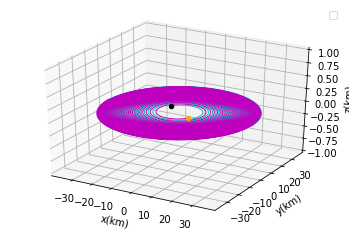

In [88]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(rPNSTO[0][0], rPNSTO[0][1], rPNSTO[0][2], 'c', linewidth=1)# Plot the BH orbit
ax.plot(rPNSTO[1][0], rPNSTO[1][1], rPNSTO[1][2], 'm', linewidth=1)# Plot the star orbit
ax.scatter3D(rPNSTO[0][0][-1], rPNSTO[0][1][-1], rPNSTO[0][2][-1], '0', c='black') #s=100 markersize=40
ax.scatter3D(rPNSTO[1][0][-1], rPNSTO[1][1][-1], rPNSTO[1][2][-1], 'o', c='orange') #s=10
ax.legend()
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
#ax.set_xlim3d(-1,1)
ax.set_zlim3d(-1,1)
#ax.set_xlim3d(min(min(posbh1x), min(posbh2x)), max(max(posbh1x), max(posbh2x)))
#ax.set_ylim3d(min(min(posbh1y), min(posbh2y)), max(max(posbh1y), max(posbh2y)))
#ax.set_zlim3d(min(min(posbh1z), min(posbh2z)), max(max(posbh1z), max(posbh2z)))
ax.set_xlabel('x(km)')
ax.set_ylabel('y(km)')
ax.set_zlabel('z(km)')


#plt.savefig('TPNcol.png', bbox_inches='tight', dpi=300)#, dpi=200
#plt.savefig('PNorbitaldecay.eps', format='eps')#,

plt.show()

In [ ]:
rrelPNSTO = rPNSTO[0] - rPNSTO[1]
vrelPNSTO = vPNSTO[0] - vPNSTO[1]
#rfnsbh = rrelnsbh.T[-1]

#Obtain the orbital distance
dPNSTO = np.zeros(len(rrelPNSTO .T)) 

for i in range(len(rrelPNSTO.T)):
    dPNSTO[i] = np.linalg.norm(rrelPNSTO.T[i])
    
#Obtain the relative velocity
vnPNSTO = np.zeros(len(vrelPNSTO.T)) 

for i in range(len(vrelPNSTO.T)):
    vnPNSTO[i] = np.linalg.norm(vrelPNSTO.T[i])

In [ ]:
print(np.linalg.norm(rrelPNSTO.T[-1]))

In [ ]:
vnPNSTOkm = vnPNSTO/kmsec_U*1000/c_SI
timePNSTOsec = timePNSTO*time_U

In [ ]:
wsPNSTO = np.zeros([len(dPNSTO)])

for i in range(len(dPNSTO)):
    wsPNSTO[i] = ((nsspin.mass+nsspin.mass)/dPNSTO[i]**3)**(1./2) 
    
hplusPNSTO = np.zeros([len(dPNSTO)]) #Could use Nsteps
#hcrossnsbh = np.zeros([len(dsimnsbh)])
#ro = 1.23*10**(22)#in km. LIGO's first detection, generated by two black holes some 1.3 billion light years away.
ro = 1.23*10**(21)

iangle = np.pi/2# i = pi/2 -> hx vanishes, i = 0 -> h+ and h- have the same amplitude

mu = (nsspin.mass*nsspin.mass)/(nsspin.mass+nsspin.mass)

for i in range(len(dPNSTO)):
    hplusPNSTO[i] = (1./ro)*(4*mu*(wsPNSTO[i]**2)*(dPNSTO[i]**2)/c_CU**4)*((1+np.cos(iangle)**2)/2)*np.cos(2*wsPNSTO[i]*timePNSTO[i])
    #hcross[i] = (1./ro)*(4*mu*(ws[i]**2)*(dsim[i]**2)/c_CU**4)*np.cos(iangle)*np.sin(2*ws[i]*timesimtp[i])

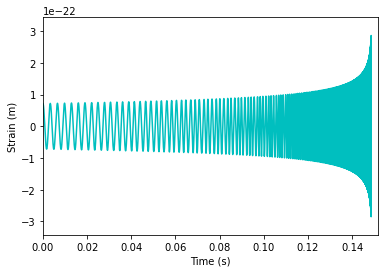

In [95]:
plt.plot(timePNSTOsec, hplusPNSTO, 'c-')
plt.axis([min(timePNSTO), 1.02*max(timePNSTOsec), 1.2*min(hplusPNSTO), 1.2*max(hplusPNSTO)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gwnsbh.png', format='png', dpi=200)
plt.show()

# Two Stars Spinning Equal spin $\chi = 0.1$ 

In [ ]:
nsnsspin2 = md.Binary(nsspin,nsspin, 8*nsspin.radi,0)#Change from 8 to 10

In [ ]:
rPNSTO2,vPNSTO2,SPNSTO2,bPNSTO2,aPNSTO2,aN_PNSTO2,aPN_PNSTO2, timePNSTO2 = Hermite4thPNSTdt(nsspin,nsspin, nsnsspin2, Nsteps, dt)

No handles with labels found to put in legend.


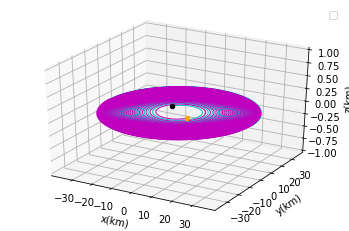

In [118]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(rPNSTO2[0][0], rPNSTO2[0][1], rPNSTO2[0][2], 'c', linewidth=1)# Plot the BH orbit
ax.plot(rPNSTO2[1][0], rPNSTO2[1][1], rPNSTO2[1][2], 'm', linewidth=1)# Plot the star orbit
ax.scatter3D(rPNSTO2[0][0][-1], rPNSTO2[0][1][-1], rPNSTO2[0][2][-1], '0', c='black') #s=100 markersize=40
ax.scatter3D(rPNSTO2[1][0][-1], rPNSTO2[1][1][-1], rPNSTO2[1][2][-1], 'o', c='orange') #s=10
ax.legend()
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_zticks([])
#ax.set_xlim3d(-1,1)
ax.set_zlim3d(-1,1)
#ax.set_xlim3d(min(min(posbh1x), min(posbh2x)), max(max(posbh1x), max(posbh2x)))
#ax.set_ylim3d(min(min(posbh1y), min(posbh2y)), max(max(posbh1y), max(posbh2y)))
#ax.set_zlim3d(min(min(posbh1z), min(posbh2z)), max(max(posbh1z), max(posbh2z)))
ax.set_xlabel('x(km)')
ax.set_ylabel('y(km)')
ax.set_zlabel('z(km)')


#plt.savefig('TPNcol.png', bbox_inches='tight', dpi=300)#, dpi=200
#plt.savefig('PNorbitaldecay.eps', format='eps')#,

plt.show()

In [ ]:
rrelPNSTO2 = rPNSTO2[0] - rPNSTO2[1]
vrelPNSTO2 = vPNSTO2[0] - vPNSTO2[1]
#rfnsbh = rrelnsbh.T[-1]

#Obtain the orbital distance
dPNSTO2 = np.zeros(len(rrelPNSTO2.T)) 

for i in range(len(rrelPNSTO2.T)):
    dPNSTO2[i] = np.linalg.norm(rrelPNSTO2.T[i])
    
#Obtain the relative velocity
vnPNSTO2 = np.zeros(len(vrelPNSTO2.T)) 

for i in range(len(vrelPNSTO2.T)):
    vnPNSTO2[i] = np.linalg.norm(vrelPNSTO2.T[i])

In [ ]:
vnPNSTO2km = vnPNSTO2/kmsec_U*1000/c_SI
timePNSTO2sec = timePNSTO2*time_U

In [ ]:
wsPNSTO2 = np.zeros([len(dPNSTO2)])

for i in range(len(dPNSTO2)):
    wsPNSTO2[i] = ((nsspin.mass+nsspin.mass)/dPNSTO2[i]**3)**(1./2) 
    
hplusPNSTO2 = np.zeros([len(dPNSTO2)]) #Could use Nsteps
#hcrossnsbh = np.zeros([len(dsimnsbh)])
#ro = 1.23*10**(22)#in km. LIGO's first detection, generated by two black holes some 1.3 billion light years away.
ro = 1.23*10**(21)

iangle = np.pi/2# i = pi/2 -> hx vanishes, i = 0 -> h+ and h- have the same amplitude

mu = (nsspin.mass*nsspin.mass)/(nsspin.mass+nsspin.mass)

for i in range(len(dPNSTO2)):
    hplusPNSTO2[i] = (1./ro)*(4*mu*(wsPNSTO2[i]**2)*(dPNSTO2[i]**2)/c_CU**4)*((1+np.cos(iangle)**2)/2)*np.cos(2*wsPNSTO2[i]*timePNSTO2[i])
    #hcross[i] = (1./ro)*(4*mu*(ws[i]**2)*(dsim[i]**2)/c_CU**4)*np.cos(iangle)*np.sin(2*ws[i]*timesimtp[i])

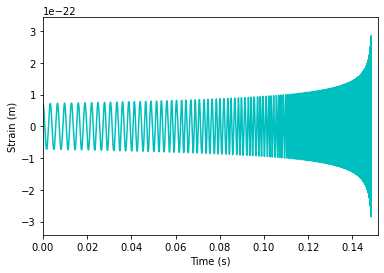

In [122]:
plt.plot(timePNSTO2sec, hplusPNSTO2, 'c-')
plt.axis([min(timePNSTO2sec), 1.02*max(timePNSTO2sec), 1.2*min(hplusPNSTO2), 1.2*max(hplusPNSTO2)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gwnsbh.png', format='png', dpi=200)
plt.show()

# Comparison of all Waveforms 

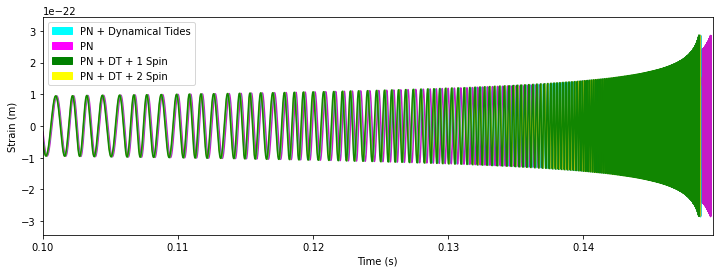

In [132]:
plt.figure(figsize=(12, 4))

cyan_patch = mpatches.Patch(color='cyan', label=r'PN + Dynamical Tides')
magenta_patch = mpatches.Patch(color='magenta', label=r'PN')
green =  mpatches.Patch(color='green', label=r'PN + DT + 1 Spin')
yellow = mpatches.Patch(color='yellow', label=r'PN + DT + 2 Spin') 
plt.legend(handles=[cyan_patch, magenta_patch, green, yellow])
plt.plot(timePNsec, hplusPN, 'm-', alpha = 0.9)
plt.plot(timePNTOsec, hplusPNTO, 'c-', alpha = 0.9)
plt.plot(timePNSTOsec, hplusPNSTO, 'y-', alpha = 0.9)
plt.plot(timePNSTO2sec, hplusPNSTO2, 'g-', alpha = 0.9)
plt.axis([0.10, 1.0009*max(timePNsec), 1.2*min(hplusPN), 1.2*max(hplusPN)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gw-PNvsPNTO-8rs-01.eps', bbox_inches='tight') #, dpi=300
plt.show()

In [ ]:
plt.figure(figsize=(12, 4))
magenta_patch = mpatches.Patch(color='magenta', label=r'PN')
cyan_patch = mpatches.Patch(color='cyan', label=r'PN + DT')
green =  mpatches.Patch(color='green', label=r'PN + DT + Spin (Only one NS)')
yellow = mpatches.Patch(color='yellow', label=r'PN + DT + Spin (Both NSs)') 
plt.legend(handles=[cyan_patch, magenta_patch, green, yellow])
plt.plot(timePNsec, hplusPN, 'm-', alpha = 0.9)
plt.plot(timePNTOsec, hplusPNTO, 'c-', alpha = 0.9)
plt.plot(timePNSTOsec, hplusPNSTO, 'y-', alpha = 0.9)
plt.plot(timePNSTO2sec, hplusPNSTO2, 'g-', alpha = 0.9)
plt.axis([0.1475, 1.0001*max(timePNsec), 1.2*min(hplusPN), 1.2*max(hplusPN)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gw-nsns-8rs-005.eps', bbox_inches='tight') #, dpi=300
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/home/irvin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  
/home/irvin/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.

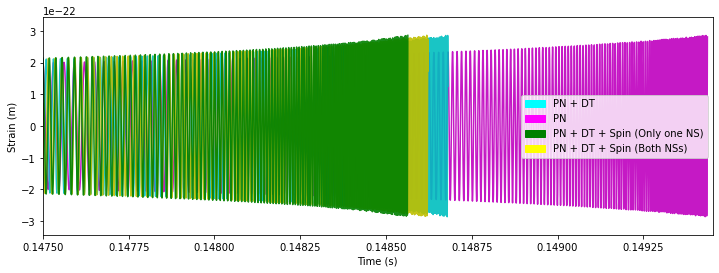

In [136]:
plt.figure(figsize=(12, 4))
magenta_patch = mpatches.Patch(color='magenta', label=r'PN')
cyan_patch = mpatches.Patch(color='cyan', label=r'PN + DT')
green =  mpatches.Patch(color='green', label=r'PN + DT + Spin (Only one NS)')
yellow = mpatches.Patch(color='yellow', label=r'PN + DT + Spin (Both NSs)') 
plt.legend(handles=[cyan_patch, magenta_patch, green, yellow])
plt.plot(timePNsec, hplusPN, 'm-', alpha = 0.9)
plt.plot(timePNTOsec, hplusPNTO, 'c-', alpha = 0.9)
plt.plot(timePNSTOsec, hplusPNSTO, 'y-', alpha = 0.9)
plt.plot(timePNSTO2sec, hplusPNSTO2, 'g-', alpha = 0.9)
plt.axis([0.1475, 1.0001*max(timePNsec), 1.2*min(hplusPN), 1.2*max(hplusPN)])
plt.xlabel('Time (s)')
plt.ylabel('Strain (m)')
#plt.savefig('gw-nsns-8rs-005.eps', bbox_inches='tight') #, dpi=300
plt.show()